# Plotting Results

## Learning Objectives

In this tutorial you will learn about the plotting functionality in LSDB.

## Introduction

LSDB makes it easy to make astronomical plots from catalogs with a spherical projection. There are a number of built-in plotting functions that you can use with `Catalog` objects for this.

## 1. Load the catalog

We will use Gaia DR3 catalog, limiting to just a few columns to reduce overall memory consumption.

In [1]:
from astropy.coordinates import SkyCoord

import lsdb
import astropy.units as u
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client

client = Client(n_workers=4, memory_limit="auto")
gaia = lsdb.open_catalog("/epyc/data3/hats/catalogs/gaia_dr3/", columns=["ra", "dec", "phot_g_mean_mag"])

## 2. Plotting HATS HEALPix structures

The first is `plot_pixels` which plots the HEALPix pixels that show the partitioning structure of how the catalog data is divided.

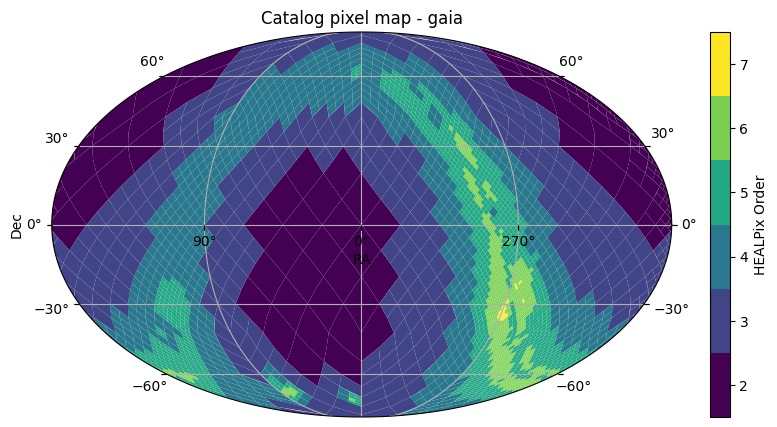

In [3]:
fig, ax = gaia.plot_pixels()

### 2.1. Limiting the field of view

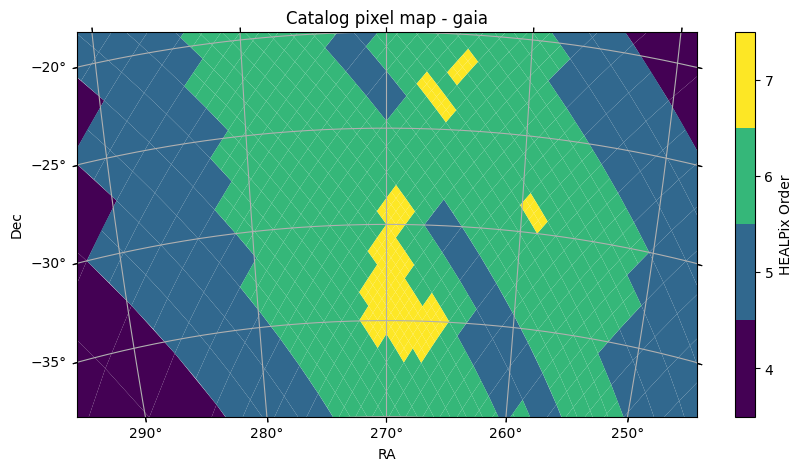

In [4]:
fov = (40 * u.deg, 20 * u.deg)
center = SkyCoord(270 * u.deg, -30 * u.deg)
fig, ax = gaia.plot_pixels(projection="AIT", fov=fov, center=center)

## 3. Plotting points

We can also plot the points of a catalog as a scatter plot with the same projected axes. This will compute the data in the catalog for the points within the field of view of the plot.

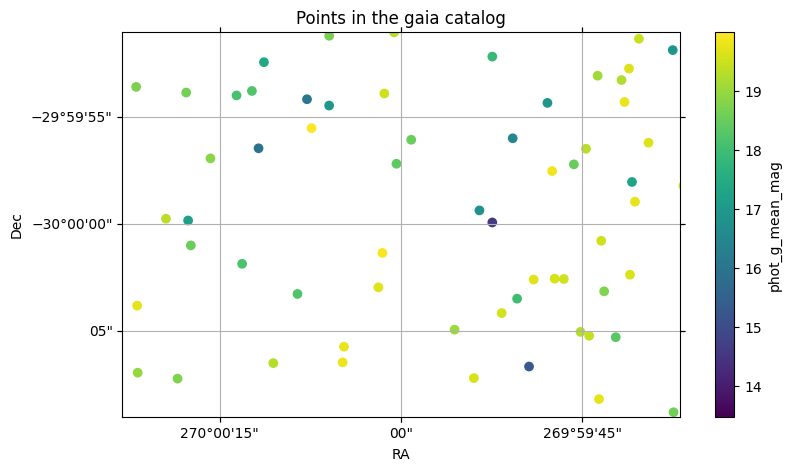

In [5]:
fig, ax = gaia.plot_points(fov=20 * u.arcsec, center=center, color_col="phot_g_mean_mag")

With this plot, we also see how a column can be used with a colormap to visualize the column values.


## 4. Multiple Plotting Calls

When multiple LSDB spatial plotting calls are called, they all plot to the same axes. The first call initializes the axes with the given WCS parameters, and any further calls reuse these same axes and parameters. If you want to plot on different axes or figures, you can call `plt.show()` between plotting calls, or pass the `ax` or `fig` parameters to plot on a specific axes or figure.

/astro/users/mmd11/.conda/envs/importenv/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:147: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


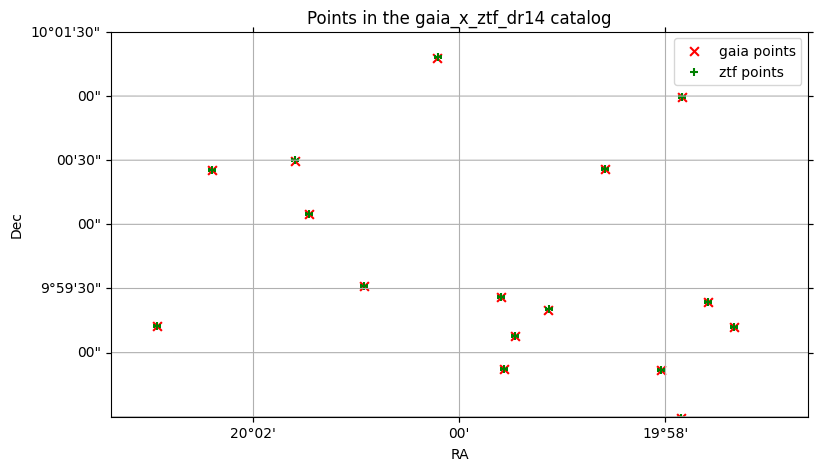

In [6]:
ztf = lsdb.open_catalog("https://data.lsdb.io/hats/ztf_dr14/ztf_object")
xmatched_cat = gaia.crossmatch(ztf)

xmatched_cat.plot_points(
    fov=200 * u.arcsec,
    center=SkyCoord(20 * u.deg, 10 * u.deg),
    c="red",
    marker="x",
    s=40,
    label="gaia points",
)
xmatched_cat.plot_points(
    ra_column="ra_ztf_dr14", dec_column="dec_ztf_dr14", c="green", marker="+", s=30, label="ztf points"
)
l = plt.legend()

By default, the catalog's main `ra` and `dec` columns are used to plot the points, but if there are multiple `ra` and `dec` columns, (for example, the right catalog in a crossmatch), these can be specified.

`plot_points` under the hood uses matplotlib's `scatter` function, so any keyword arguments that work with scatter will work with `plot_points`.

## 5. Plotting aggregations of data

You can also create a user-defined function to aggregate HEALPix pixels, either at a custom order, or the original order of the catalog data partitions.

See the [tuturial on `map_partitions`](https://docs.lsdb.io/en/latest/tutorials/pre_executed/map_partitions.html) for more details on applying user-defined functions to all data partitions in a catalog.

For a simple example, to plot the number of points in each healpix pixel within a cone, you can do the following:

In [7]:
import pandas as pd
from lsdb.dask.merge_catalog_functions import filter_by_spatial_index_to_pixel
import numpy as np


def per_pixel_len(df, pixel, target_order=10):
    if len(df) == 0:
        return pd.DataFrame(data={"pixel": [pixel], "len": [0]})
    # Within each data partition, divide into smaller partitions at `target_order`
    delta_order = target_order - pixel.order
    pixels = np.arange(pixel.pixel << (2 * delta_order), (pixel.pixel + 1) << (2 * delta_order))
    # Use np.vectorize to make the operation faster within each data partition.
    # In this case, we have a very simple lambda function to aggregate the data.
    lengths = np.vectorize(lambda p: len(filter_by_spatial_index_to_pixel(df, target_order, p)))(pixels)

    return pd.DataFrame(data={"pixel": pixels, "len": lengths})

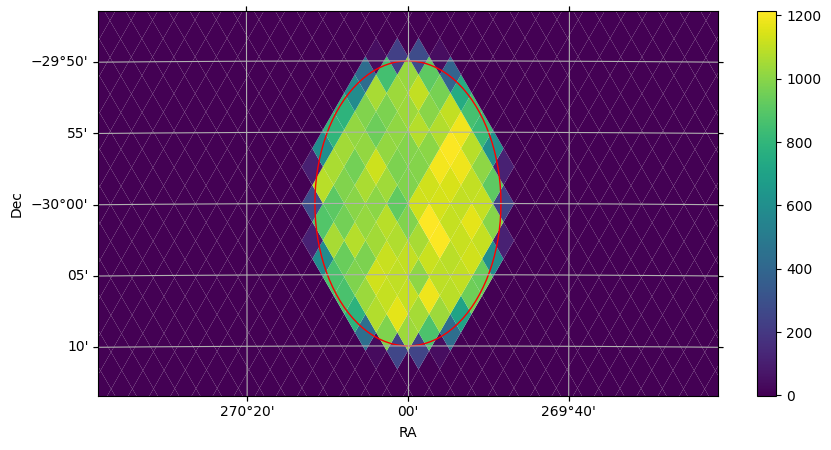

In [8]:
from lsdb import ConeSearch
from hats.inspection.visualize_catalog import plot_healpix_map
import hats.pixel_math.healpix_shim as hp

# Tune this to get more granular data
target_order = 11

cone_search = ConeSearch(center.ra.deg, center.dec.deg, 10 * 60)
cone_data = (
    gaia.search(cone_search)
    .map_partitions(per_pixel_len, include_pixel=True, target_order=target_order)
    .compute()
)

# Create an empty histogram of ALL pixels in the sky, and fill just where we have data
npix = hp.order2npix(target_order)
img = np.full(npix, -1)
img[cone_data["pixel"]] = cone_data["len"]

# Plot our values, zooming in on our cone search and highlighting the cone region with a red outline
plot_healpix_map(img, fov=(60 * u.arcmin, 30 * u.arcmin), center=center)
fig, ax = cone_search.plot(fc="#00000000", ec="red")

## 6. Plotting Search Filters

In the plot above, we also see how search filters can be plotted with `cone_search.plot(fc="#00000000", ec="red")`. The plot function plots the correct shape of the filter on the spherical projection, with any additional kwargs passed to the creation of a matplotlib `Patch` object.

## 7. Histograms

Suppose we want to bin observations in the Gaia DR3 catalog by magnitude in the G band. For a small area of the sky, we could pull it all into memory and use `pd.DataFrame.hist`, but to run the histogram across the entire catalog, we'll need `.map_partitions`.

We'll limit the catalog with a `ConeSearch` to begin with, so that we can test our approach with a smaller amount of data.

In [9]:
import lsdb

# catalog_root = "https://data.lsdb.io/hats"
catalog_root = "/epyc/data3/hats/catalogs"
gaia3 = lsdb.open_catalog(
    f"{catalog_root}/gaia_dr3",
    margin_cache="gaia_10arcs",
    search_filter=lsdb.ConeSearch(ra=280, dec=-60, radius_arcsec=2 * 3600),
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
gaia3

,source_id,ra,dec,phot_g_mean_mag,phot_g_n_obs
npartitions=4,,,,,
"Order: 4, Pixel: 2944",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow]
"Order: 4, Pixel: 2945",...,...,...,...,...
"Order: 4, Pixel: 2946",...,...,...,...,...
"Order: 4, Pixel: 2947",...,...,...,...,...


### 7.1. All Within Memory

First, what does it look like to do it all within memory? This slice of the catalog is small enough to do this.

In [10]:
%%time
df = gaia3.compute()
df

CPU times: user 20.8 ms, sys: 7.41 ms, total: 28.2 ms
Wall time: 111 ms


,source_id,ra,dec,phot_g_mean_mag,phot_g_n_obs
_healpix_29,,,,,
3315212135629220059,6630424242158614528,279.475941,-61.973682,20.157476,298
3315212197603296958,6630424379597543936,279.40738,-61.977054,19.488537,346
...,...,...,...,...,...
3318663093295462547,6637326190180387584,280.426265,-58.015067,21.097507,42
3318663093808668415,6637326185883831296,280.423503,-58.013744,20.301455,336


Note that the four partitions become over 450k rows once they are computed.  The lazily-loaded
catalog can't show you how many total rows there are before computing, only the number of
partitions.

20

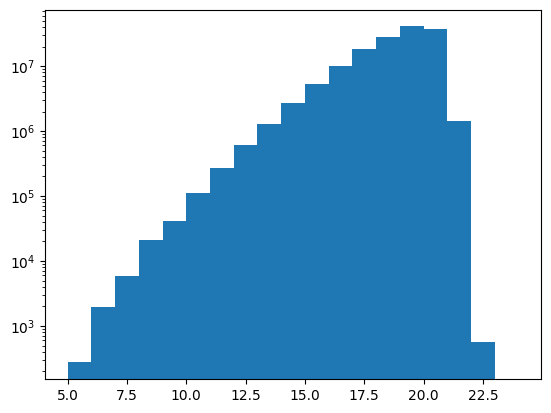

In [11]:
from matplotlib import pyplot as plt

mag_bins = list(range(5, 25, 1))
display(len(mag_bins))
plt.hist(df["phot_g_mean_mag"], bins=mag_bins, weights=df["phot_g_n_obs"])
plt.yscale("log")

### 7.2 Across the Sky

Now to move on to the whole catalog. We need to design a function that can operate independently on each partition. Each row of each partition contains some number of observations, and we want to sum these observations within each magnitude bin.

We'll test this function on the same small piece of data before launching
it across the entire catalog.

We will use this function to create partial histograms,
a histogram for each partition, and we'll need to reduce those
down to a single histogram at the end.  One consequence of this is
the need to have the same number of bins in each partial histogram,
`mag_bins` in this case.  Often when producing a histogram, it's common
to let Pandas or `pd.cut` pick the bin boundaries given a number of
bins, but that will work against us in this case, since each partition
will have a different min and max, and the partial histograms won't
reduce.

In [12]:
# This function only requires and returns one DataFrame: no pixel
# argument, no additional arguments.
def observation_histogram(df):
    df["binned"] = pd.cut(df["phot_g_mean_mag"], mag_bins)
    binned_data = df.groupby("binned", observed=True)["phot_g_n_obs"].sum()
    return pd.DataFrame(binned_data)

Test our new function on our single in-memory `DataFrame`, `df`, to
verify that we get the results we expect.

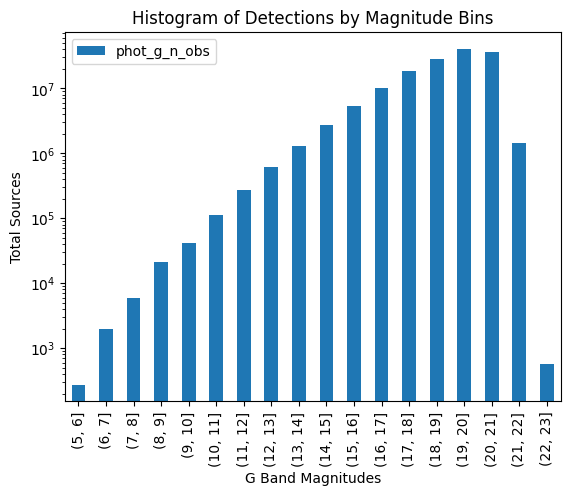

CPU times: user 150 ms, sys: 12 ms, total: 162 ms
Wall time: 170 ms


In [13]:
%%time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots()

bd = observation_histogram(df)

bd.plot(kind="bar", ax=ax, label="Observations")

ax.set_title("Histogram of Detections by Magnitude Bins")
ax.set_xlabel("G Band Magnitudes")
ax.set_ylabel("Total Sources")

ax.legend()
ax.set_yscale("log")

plt.show()

### 7.2.1 Using map_partitions

Next, exercise this function with `map_partitions`, on the original catalog, which
has been limited by a cone search to keep it tractable.

In [14]:
%%time
result = gaia3.map_partitions(observation_histogram).compute()
result

CPU times: user 37.6 ms, sys: 878 μs, total: 38.5 ms
Wall time: 111 ms


,phot_g_n_obs
binned,
"(8, 9]",2811
"(9, 10]",4784
...,...
"(20, 21]",11124220
"(21, 22]",493954


The above contains a histogram for each partition. We need to do a final reduction step to get the complete histogram, grouping by `"binned"`.

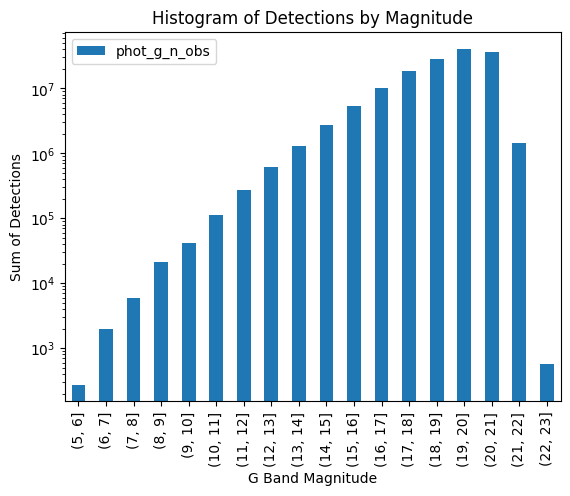

In [15]:
total_histogram = result.groupby("binned", observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind="bar", ax=ax)
ax.set_title("Histogram of Detections by Magnitude")
ax.set_xlabel("G Band Magnitude")
ax.set_ylabel("Sum of Detections")
ax.set_yscale("log")
plt.show()

This gives us confidence because it matches what happened when we applied our function to the in-memory `df` that resulted from calling `.compute()` on our cone search. Now we can confidently apply it to the entire catalog:

In [16]:
gaia3 = lsdb.open_catalog(
    f"{catalog_root}/gaia_dr3",
    margin_cache="gaia_10arcs",
    columns=[
        "source_id",
        "ra",
        "dec",
        "phot_g_mean_mag",
        "phot_g_n_obs",
    ],
)
unrealized = gaia3.map_partitions(observation_histogram)
display(unrealized.npartitions)

3933

In [17]:
%%time
# Takes a few minutes on epyc, using local catalog root
result = unrealized.compute()
# This is actually the histogram repeated for each partition.
result

CPU times: user 6.92 s, sys: 156 ms, total: 7.07 s
Wall time: 21.1 s


,phot_g_n_obs
binned,
"(5, 6]",3297
"(6, 7]",7250
...,...
"(21, 22]",4548691
"(22, 23]",7823


Again, the final reduction and plot.

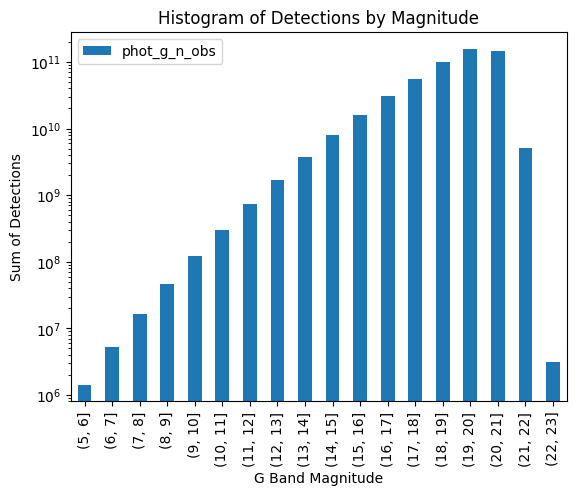

In [18]:
total_histogram = result.groupby("binned", observed=True).sum()

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
total_histogram.plot(kind="bar", ax=ax)
ax.set_title("Histogram of Detections by Magnitude")
ax.set_xlabel("G Band Magnitude")
ax.set_ylabel("Sum of Detections")
ax.set_yscale("log")
plt.show()

The histogram has the same shape but larger values on the Y-axis:
our small cone search had picked a part of the sky which was representative
of the whole, but processing the entire catalog increased the number
of observations across all bins.

Close our Dask client now that we're done with it.

In [19]:
client.close()

## About

**Authors**: Sean McGuire

**Last updated /verified on**:  October 27, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).